In [14]:
import torch
import numpy as np
from torch.nn import LSTM
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import yfinance as yf
yf.pdr_override()



In [15]:
!pip3 install yfinance

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/
You should consider upgrading via the '/data/projects/fate/env/python/venv/bin/python -m pip install --upgrade pip' command.


In [16]:
def Date_cut(df, start_date = '2013-01-01', end_date = '2022-12-31'):
    return df.loc[(df.index >= start_date) & (df.index<= end_date)]


In [17]:
# SSE_start = '2013-01-01'
# SSE_end =  '2022-12-31'
ETH_start = '2018-01-01'
ETH_end =  '2022-12-31'
# df_SSE = data.get_data_yahoo(tickers='000001.ss',start='2013-01-01', end='2022-12-31')
# df_SSE = Date_cut(df_SSE, SSE_start, SSE_end)
# print("SSE data size:", len(df_SSE.index))

df_ETH = pd.read_csv('./ETH-USD.csv',index_col = 0)
df_ETH = Date_cut(df_ETH, ETH_start, ETH_end)
print("ETH data size:", len(df_ETH.index))

ETH data size: 1826


/data/projects/fate/env/python/venv/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 65509 (\N{FULLWIDTH YEN SIGN}) missing from current font.
  func(*args, **kwargs)
/data/projects/fate/env/python/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65509 (\N{FULLWIDTH YEN SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


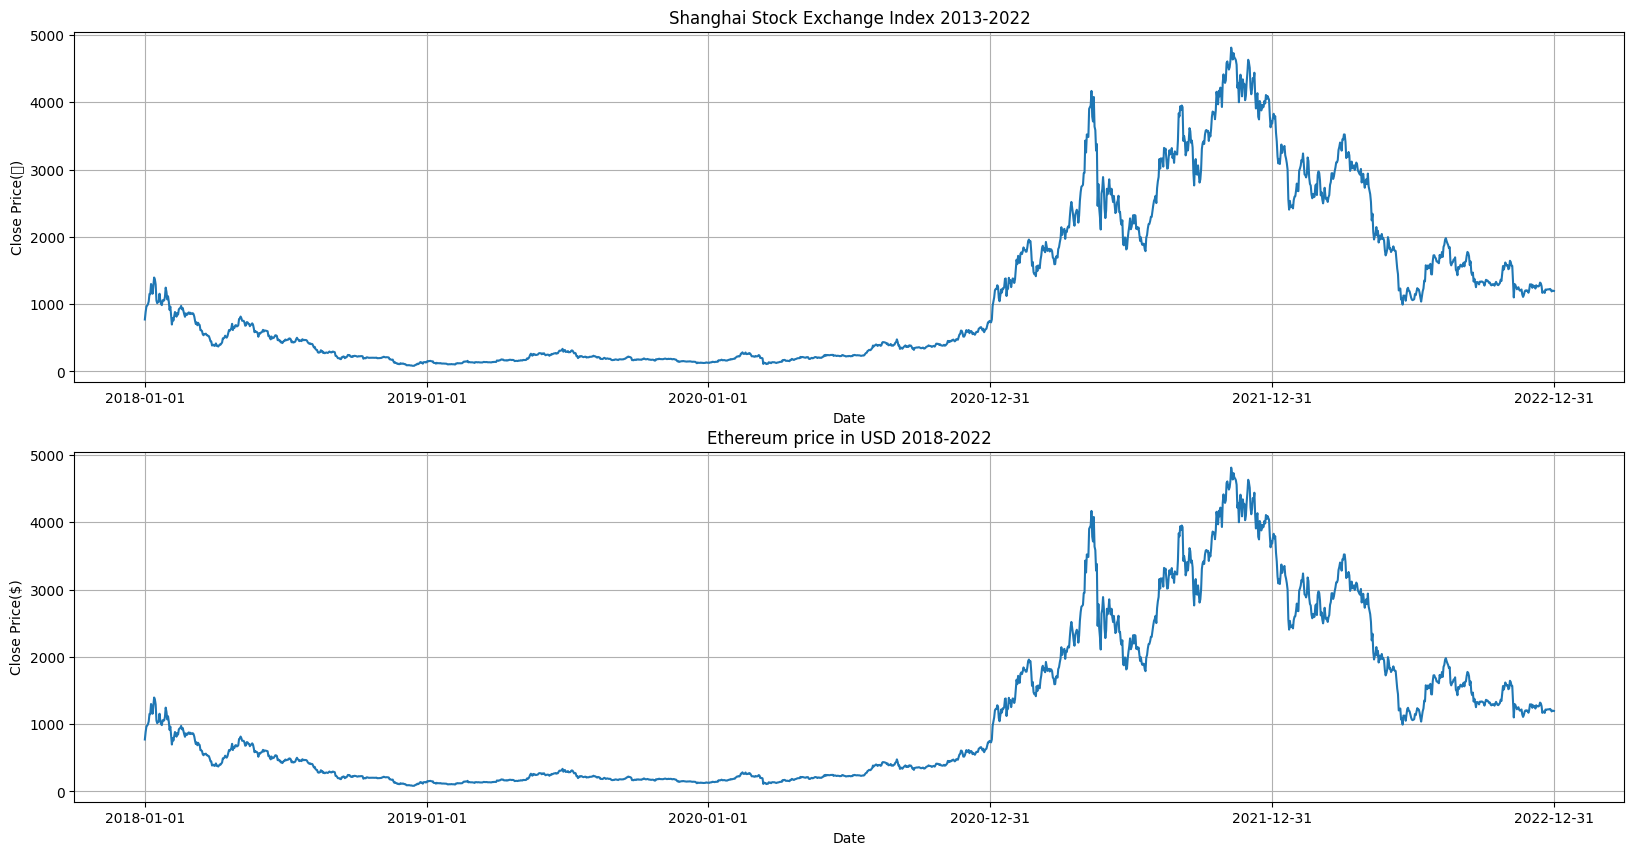

In [18]:
tick_spacing = 365
fig = plt.figure(figsize = (20,10))
sse = fig.add_subplot(211)
sse.set_title("Shanghai Stock Exchange Index 2013-2022")
sse.set_xlabel("Date")
sse.set_ylabel("Close Price(￥)")
sse.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing ))
sse.plot(df_ETH.loc[:,"Close"])
# sse.plot(df_SSE)
sse.grid()
eth = fig.add_subplot(212)
eth.set_title("Ethereum price in USD 2018-2022")
eth.set_xlabel("Date")
eth.set_ylabel("Close Price($)")
eth.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing ))
eth.plot(df_ETH.loc[:,"Close"])
# eth.plot(df_ETH)
eth.grid()

In [19]:

train_proportial = 0.8

close = df_ETH.loc[:,"Close"]
training_size=int(len(close)*train_proportial)
train_data = close[:training_size]
test_data = close[training_size:]

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
train_data_normalized = scaler.fit_transform(np.array(train_data).reshape(-1,1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [21]:
def make_xySeq(tran_data, window_size=10, predict_gap=5):
    xySeq = []
    for i in range(len(tran_data)-window_size-predict_gap):
        x = tran_data[i:i+window_size]
        y = tran_data[i+window_size+predict_gap]
        xySeq.append((x,y))
    return xySeq 



In [22]:
train_seq = make_xySeq(train_data_normalized)

In [23]:
from torch.autograd import Variable
class myLSTM(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim) -> None:
        super(myLSTM, self).__init__()
        self.lstm = LSTM(input_size=in_dim, hidden_size=hidden_dim)
        self.liner = torch.nn.Linear(in_features=hidden_dim, out_features=out_dim) 
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim

    def forward(self, seq):
        # print(seq.view(len(seq),1,-1))
        h_0 = Variable(torch.zeros(1, 1, self.hidden_dim).cpu())
        c_0 = Variable(torch.zeros(1, 1, self.hidden_dim).cpu())
        # print(c_0)
        lstm_out, (hidden_state, cell_state) = self.lstm(seq.view(len(seq),1,-1),(h_0,c_0))
        # if len(seq)!=self.in_dim:
        #     print(f"The expected length of input sequence is {self.in_dim}, but get {len(seq)}.")
        #     return
        
        # lstm_out = lstm_out.view(-1,self.hidden_dim)
        # print(lstm_out.shape)

        prediction = self.liner(hidden_state[-1])
        # prediction = self.liner(lstm_out.view(-1,self.hidden_dim))
        # print(prediction.shape)

        # liner2 = torch.nn.Linear(in_features=len(seq),out_features=1)
        # prediction = liner2(prediction.view(-1,len(prediction)))
        return prediction

In [24]:
kwargs = {"input_size":10,
          "hidden_size":10,
          "target_size":1}
# network = LSTM(**kwargs)
network = myLSTM(1,100,1)
# network = torch.nn.Sequential(
#     torch.nn.Linear(in_features=1,out_features=10),
#     torch.nn.ReLU(),
#     torch.nn.LSTM(input_size=10,hidden_size = 100),
#     # torch.nn.Sigmoid()
#     torch.nn.Linear(in_features=100, out_features=1)
# )
loss_func = torch.nn.MSELoss()
optimizier = torch.optim.Adam(network.parameters(), lr=0.001)


In [25]:
y_preds = []
y_gt = []
for x, y in train_seq:
    with torch.no_grad():
        # x = x.view(len(x),1,-1)
        # print(x.shape)
        y_hat = network(x).item()
        y_preds.append(y_hat)
        y_gt.append(y)

print(y_preds)

[-0.028292367234826088, -0.028155626729130745, -0.028250737115740776, -0.028474517166614532, -0.028535060584545135, -0.02844560146331787, -0.028056880459189415, -0.027814405038952827, -0.027746206149458885, -0.027733923867344856, -0.027902618050575256, -0.027838151901960373, -0.027736825868487358, -0.027666952461004257, -0.02774207480251789, -0.027779046446084976, -0.02779320254921913, -0.027872318401932716, -0.02810749039053917, -0.028126005083322525, -0.027964815497398376, -0.02794910967350006, -0.02782994695007801, -0.02760111540555954, -0.027565907686948776, -0.027376651763916016, -0.027095947414636612, -0.027108581736683846, -0.0270804725587368, -0.02715929225087166, -0.027296151965856552, -0.027327775955200195, -0.027271810919046402, -0.027318822219967842, -0.027309397235512733, -0.02741406485438347, -0.027482779696583748, -0.027521496638655663, -0.027578013017773628, -0.027530228719115257, -0.027531756088137627, -0.027463646605610847, -0.027365297079086304, -0.02726788818836212,

In [26]:
EPOCHS = 100
for epoch in range(EPOCHS):
    for x, y in train_seq:
        network.zero_grad()

        y_hat = network(x)
        loss = loss_func(y_hat,y)
        loss.backward()
        optimizier.step()

    print(f'epoch: {epoch:3} loss: {loss.item():10.8f}')

/data/projects/fate/env/python/venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 loss: 0.00801926
epoch:   1 loss: 0.00072946
epoch:   2 loss: 0.00100313
epoch:   3 loss: 0.00108860
epoch:   4 loss: 0.00142260
epoch:   5 loss: 0.00251296
epoch:   6 loss: 0.00253001
epoch:   7 loss: 0.00248746
epoch:   8 loss: 0.00248892
epoch:   9 loss: 0.00264272
epoch:  10 loss: 0.00260646
epoch:  11 loss: 0.00256250
epoch:  12 loss: 0.00261061
epoch:  13 loss: 0.00260371
epoch:  14 loss: 0.00264021
epoch:  15 loss: 0.00262377
epoch:  16 loss: 0.00261604
epoch:  17 loss: 0.00262959
epoch:  18 loss: 0.00262814
epoch:  19 loss: 0.00265650
epoch:  20 loss: 0.00267577
epoch:  21 loss: 0.00271252
epoch:  22 loss: 0.00274993
epoch:  23 loss: 0.00280767
epoch:  24 loss: 0.00286873
epoch:  25 loss: 0.00294296
epoch:  26 loss: 0.00303117
epoch:  27 loss: 0.00314449
epoch:  28 loss: 0.00326568
epoch:  29 loss: 0.00343145
epoch:  30 loss: 0.00362997
epoch:  31 loss: 0.00385391
epoch:  32 loss: 0.00412989
epoch:  33 loss: 0.00443349
epoch:  34 loss: 0.00462911
epoch:  35 loss: 0.0

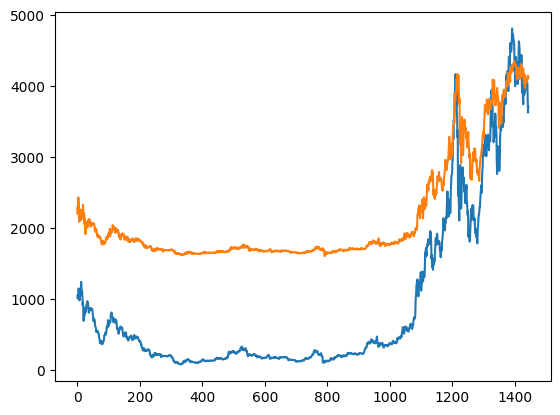

In [27]:
# test_data_normalized = scaler.fit_transform(np.array(test_data).reshape(-1,1))
# test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
# test_seq = make_xySeq(test_data_normalized)

y_preds_train = []
y_gt = []
for x, y in train_seq:
    with torch.no_grad():
        y_hat = network(x).item()
        y_preds_train.append(y_hat)
        y_gt.append(y)

y_preds_train = scaler.inverse_transform(np.array(y_preds_train).reshape(-1,1))
y_gt = scaler.inverse_transform(np.array(y_gt).reshape(-1,1))
# print(y_preds)
# plt.autoscale(axis='x', tight=True)
plt.plot(y_gt)
plt.plot(y_preds_train)

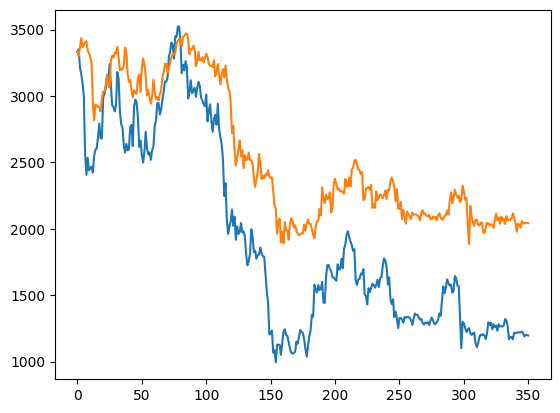

In [28]:
test_data_normalized = scaler.fit_transform(np.array(test_data).reshape(-1,1))
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
test_seq = make_xySeq(test_data_normalized)

y_preds_test = []
y_gt = []
for x, y in test_seq:
    with torch.no_grad():
        y_hat = network(x).item()
        y_preds_test.append(y_hat)
        y_gt.append(y)

y_preds_test = scaler.inverse_transform(np.array(y_preds_test).reshape(-1,1))
y_gt = scaler.inverse_transform(np.array(y_gt).reshape(-1,1))
# print(y_preds)
# plt.autoscale(axis='x', tight=True)
plt.plot(y_gt)
plt.plot(y_preds_test)


